In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq, least_squares
from scipy.interpolate import interp1d
import matplotlib.pylab as plt
import datetime as dt
from pprint import pprint
import math

### Data Preparation


In [3]:
#Black-Scholes Model

def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

#Displaced-Diffusion Model

def DisplacedDiffusionCall(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(F/beta*norm.cdf(c1) - ((1-beta)/beta*F + K)*norm.cdf(c2))

def DisplacedDiffusionPut(S, K, r, sigma, T, beta):
    F = np.exp(r*T)*S
    c1 = (np.log(F/(F+beta*(K-F)))+(beta*sigma)**2/2*T) / (beta*sigma*np.sqrt(T))
    c2 = c1 - beta*sigma*np.sqrt(T)
    disc = np.exp(-r*T)
    return disc*(((1-beta)/beta*F + K)*norm.cdf(-c2) - F/beta*norm.cdf(-c1))

#Implied Call & Put Volatility
    
def impliedVolatility(S, K, r, price, T, option_type):
    try:
        if option_type == 'C':
            return brentq(lambda x: price - BlackScholesCall(S, K, r, x, T), 1e-12, 12)
        else:
            return brentq(lambda x: price - BlackScholesPut(S, K, r, x, T), 1e-12, 12)
    except Exception:
        impliedVol = np.nan

        return np.nan
        
def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def ddcalibration(x, strikes, vols, S, r, sigma, T, options_type):
    # Create masks for call and put options
    call_mask = (options_type == "call")
    put_mask = (options_type == "put")

    # Compute option prices for calls and puts
    call_prices = DisplacedDiffusionCall(S, strikes[call_mask], r, sigma, T, x[0])
    put_prices = DisplacedDiffusionPut(S, strikes[put_mask], r, sigma, T, x[0])

    # Compute implied volatilities for calls and puts
    call_implied_vols = impliedVolatility(S, strikes[call_mask], r, call_prices, T, "call")
    put_implied_vols = impliedVolatility(S, strikes[put_mask], r, put_prices, T, "put")

    # Combine results back into original order
    implied_vols = np.empty_like(vols)
    implied_vols[call_mask] = call_implied_vols
    implied_vols[put_mask] = put_implied_vols

    # Compute the total error
    err = np.sum((vols - implied_vols) ** 2)* 1e6
    return err

In [4]:
df_spx = pd.read_csv("SPX_options.csv")
df_spy= pd.read_csv("SPY_options.csv")
df_rates = pd.read_csv("zero_rates_20201201.csv")

S_SPX = 3662.45
S_SPY = 366.02

In [5]:
def process_rates_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")

    def convert_rates_to_decimal(df):
        df["rate_decimal"] = df["rate"] / 100

    def interpolate_rates(df):
        df = df.drop(["date"], axis=1)
        df.set_index("days", inplace=True)
        df_reindexed = df.reindex(np.arange(df.index.min(), df.index.max() + 1))
        df_reindexed = df_reindexed.interpolate(method="linear")
        return df_reindexed

    df = df.copy()
    convert_datetime(df)
    convert_rates_to_decimal(df)
    df = interpolate_rates(df)
    return df


def process_options_data(df):
    def convert_datetime(df):
        df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
        df["exdate"] = pd.to_datetime(df["exdate"], format="%Y%m%d")

    def compute_time_to_maturity(df):
        df["days_to_expiry"] = (df["exdate"] - df["date"]) / pd.Timedelta(days=1)
        df["years_to_expiry"] = df["days_to_expiry"] / 365

    def compute_mid_price(df):
        df["mid_price"] = 0.5 * (df["best_bid"] + df["best_offer"])

    def convert_strike_price(df):
        df["strike_price"] = df["strike_price"] / 1000

    def convert_flag_to_options_type(df):
        df["options_type"] = df["cp_flag"].map(lambda x: "call" if x == "C" else "put")

    df = df.copy()
    convert_datetime(df)
    compute_time_to_maturity(df)
    compute_mid_price(df)
    convert_strike_price(df)
    convert_flag_to_options_type(df)
    return df

df_spx_processed = process_options_data(df_spx)
df_spy_processed = process_options_data(df_spy)
df_rates_processed = process_rates_data(df_rates)

In [6]:
def compute_implied_volatility_for(df_options, current_price):
    S = current_price
    days_to_expiry_arr = df_options["days_to_expiry"].unique()
    df_volatility_by_dte_dict = {}
    for day_to_expire in days_to_expiry_arr:
        df_filtered = df_options[
            df_options["days_to_expiry"] == day_to_expire
        ].reset_index(drop=True)
        rates = df_rates_processed.loc[int(df_filtered["days_to_expiry"][0])][
            "rate_decimal"
        ]
        df_filtered["implied_vol"] = df_filtered.apply(
            lambda x: impliedVolatility(
                S,
                x["strike_price"],
                rates,
                x["mid_price"],
                x["years_to_expiry"],
                x["options_type"],
            ),
            axis=1,
        )

        df_call = df_filtered[df_filtered["options_type"] == "call"]
        df_put = df_filtered[df_filtered["options_type"] == "put"]
        strikes = df_put["strike_price"].values
        implied_vols = []
        options_type = []
        for K in strikes:
            if S < K:
                options_type.append("call")
                implied_vols.append(
                    df_call[df_call["strike_price"] == K]["implied_vol"].values[0]
                )
            else:
                options_type.append("put")
                implied_vols.append(
                    df_put[df_put["strike_price"] == K]["implied_vol"].values[0]
                )
        df_implied_vols = pd.DataFrame(
            {
                "strike": strikes,
                "impliedvol": implied_vols,
                "options_type": options_type,
            }
        )
        df_volatility_by_dte_dict[str(int(day_to_expire))] = df_implied_vols
    return df_volatility_by_dte_dict


implied_vol_dict_spx = compute_implied_volatility_for(df_spx_processed, S_SPX)
implied_vol_dict_spy = compute_implied_volatility_for(df_spy_processed, S_SPY)

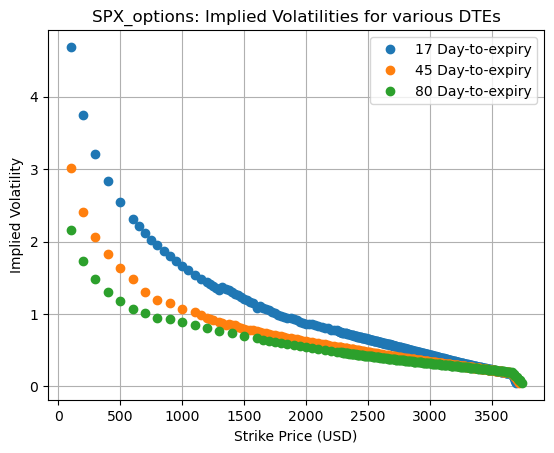

In [7]:
plt.title("SPX_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "o",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig("Part_2_market_vol_SPX_options.png")

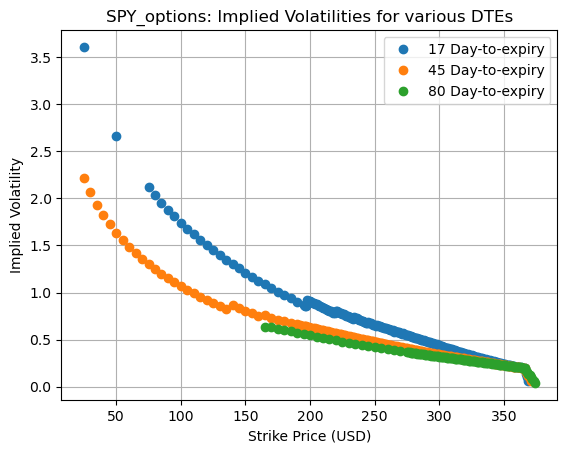

In [8]:
plt.title("SPY_options: Implied Volatilities for various DTEs")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    plt.plot(
        df_vol["strike"],
        df_vol["impliedvol"],
        "o",
        label="{} Day-to-expiry".format(day_to_expiry),
    )

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig("Part_2_market_vol_SPY_options.png")

### Displaced-Diffusion Model Calibration


#### European Options (SPX)


In [11]:
implied_vol_dict_spx = {
    key: df.dropna() for key, df in implied_vol_dict_spx.items()
}

In [31]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPX
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.1]  # beta
    res = least_squares(
        lambda x: ddcalibration(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.17085564717864088, 'beta': 0.1},
 '45': {'sigma': 0.18335871794189723, 'beta': 0.1},
 '80': {'sigma': 0.19167798865912442, 'beta': 0.1}}

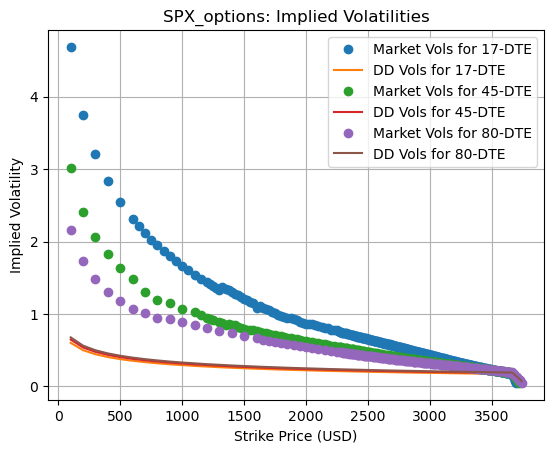

In [33]:
plt.title("SPX_options: Implied Volatilities")

for day_to_expiry, df_vol in implied_vol_dict_spx.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params = DD_params_by_dte_dict[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionCall(
                S, K, rates, sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                S, K, rates, sigma, T, beta
            )
        implied_vol = impliedVolatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)

    plt.plot(df_vol["strike"], df_vol["impliedvol"], "o", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_DD_vols_SPX_options.png")
plt.show()

#### American Options (SPY)


In [35]:
DD_params_by_dte_dict = {}

for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    S = S_SPY
    sigma = np.interp(S, df_vol["strike"], df_vol["impliedvol"])

    initial_guess = [0.1]  # beta
    res = least_squares(
        lambda x: ddcalibration(
            x,
            df_vol["strike"],
            df_vol["impliedvol"],
            S,
            rates,
            sigma,
            T,
            df_vol["options_type"],
        ),
        initial_guess,
        bounds=(0, 1),
    )
    DD_params_by_dte_dict[day_to_expiry] = {"sigma": sigma, "beta": res.x[0]}
DD_params_by_dte_dict

{'17': {'sigma': 0.20029599590444935, 'beta': 0.1},
 '45': {'sigma': 0.19687152399567828, 'beta': 0.1},
 '80': {'sigma': 0.20000544317769098, 'beta': 0.1}}

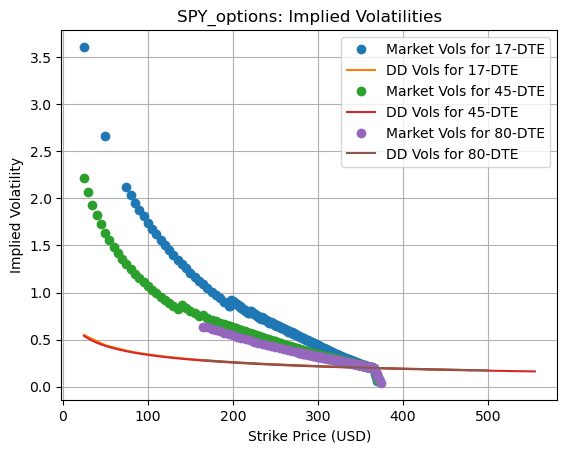

In [37]:
plt.title("SPY_options: Implied Volatilities")
for day_to_expiry, df_vol in implied_vol_dict_spy.items():
    rates = df_rates_processed.loc[int(day_to_expiry)]["rate_decimal"]
    T = float(day_to_expiry) / 365
    params = DD_params_by_dte_dict[day_to_expiry]
    beta = params["beta"]
    sigma = params["sigma"]

    ddvols = []
    for i, K in enumerate(df_vol["strike"]):
        option_type = df_vol["options_type"][i]
        if option_type == "call":
            price = DisplacedDiffusionPut (
                S, K, rates, sigma, T, beta
            )
        else:
            price = DisplacedDiffusionPut(
                S, K, rates, sigma, T, beta
            )
        implied_vol = impliedVolatility(S, K, rates, price, T, option_type)
        ddvols.append(implied_vol)
    plt.plot(df_vol["strike"], df_vol["impliedvol"], "o", label="Market Vols for {}-DTE".format(day_to_expiry))
    plt.plot(df_vol["strike"], ddvols, label="DD Vols for {}-DTE".format(day_to_expiry))

plt.grid()
plt.xlabel("Strike Price (USD)")
plt.ylabel("Implied Volatility")
plt.legend()
plt.savefig(f"Part_2_DD_vols_SPY_options.png")
plt.show()

### SABR Model Calibration


In [18]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

def DDPrice(F, K, r, sigma, T, beta, payoff):
    if (payoff.lower() == 'call'):
        DDCall(F, K, r, sigma, T, beta)
        
    elif (payoff.lower() == 'put'):
        DDPut(F, K, r, sigma, T, beta)
    else:
        raise NameError('Payoff type not recognized')

def DDCall(F, K, r, sigma, T, beta):
    if beta == 0:
        S = F*np.exp(-r*T)
        BlackScholesCall(S, K, r, sigma, T)
    else:
        BlackCall(F/beta, K+((1-beta)/beta)*F, r, sigma*beta, T)

def DDPut(F, K, r, sigma, T, beta):
    if beta == 0:
        S = F*np.exp(-r*T)
        BlackScholesPut(S, K, r, sigma, T)
    else:
        BlackPut(F/beta, K+((1-beta)/beta)*F, r, sigma*beta, T)

def BlackCall(F, K, r, sigma, T):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)* (F * norm.cdf(d1) - K*norm.cdf(d2))

def BlackPut(F, K, r, sigma, T):
    d1 = (np.log(F/K)+(sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return np.exp(-r*T)* (K * norm.cdf(-d2) - F*norm.cdf(-d1))

In [19]:
# SPX Dataset
spx_df =\
(
    pd
    .read_csv('SPX_options.csv')
)

# SPY Dataset
spy_df =\
(
    pd
    .read_csv("SPY_options.csv")
)

# Rates Dataset
rates_df =\
(
    pd
    .read_csv('zero_rates_20201201.csv')
)

In [20]:
# Project is to calculate on 1-Dec-2020
today =\
(
    dt
    .date(2020, # Year
          12,   # Month
          1)    # Date
)

# Since both datasets have same expiries, we would not be creating another one.
expiries =\
(
    [
        pd.Timestamp(str(x)).date() for x in spx_df['exdate'].unique()
    ]
)

# Time left till expiry
Time =\
(
    [
        (exdate - today).days/365.0 for exdate in expiries
    ]
)

# Calculate rates for each expiry date
days_to_expiry_list = []

for exp in expiries:
    days_to_expiry = (exp - today).days
    days_to_expiry_list.append(days_to_expiry)

zero_rate_curve =\
(
    interp1d(rates_df['days'], 
             rates_df['rate'])
)

rates =\
(
    [
        zero_rate_curve(days)/100 for days in days_to_expiry_list
    ]
)

exdates =\
(
    sorted(spx_df['exdate'].unique())
)

#### European Options (SPX)


In [22]:
for (date, T, r) in zip(exdates, Time, rates):
    df = spx_df
    S = 3662.45
    F = S*np.exp(r*T)
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    df = df[df['exdate'] == date]
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    
    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(f'Calibrated SABR model parameters for {date}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')
    
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    plt.figure(tight_layout=True)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.legend()
    plt.show()

C:\Users\wweih\AppData\Local\Temp\ipykernel_23476\3639094832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vols'] = df.apply(lambda x: impliedVolatility(S,
C:\Users\wweih\AppData\Local\Temp\ipykernel_23476\3639094832.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


IndexError: index 0 is out of bounds for axis 0 with size 0

#### American Options (SPY)


In [ ]:
for (date, T, r) in list(zip(exdates, Time, rates)):
    df = spy_df
    S = 366.02
    F = S*np.exp(r*T)
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    df = df[df['exdate'] == date]
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    
    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(f'Calibrated SABR model parameters for {date}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')
    
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    plt.figure(tight_layout=True)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.legend()
    plt.show()

In [ ]:
for (date, T, r) in list(zip(exdates, Time, rates)):
    df = spy_df
    S = 366.02
    F = S*np.exp(r*T)
    df['mid'] = 0.5*(df['best_bid'] + df['best_offer'])
    df['strike'] = df['strike_price']*0.001
    df['payoff'] = df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
    df = df[df['exdate'] == date]
    df['vols'] = df.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
    df.dropna(inplace=True)
    call_df = df[df['payoff'] == 'call']
    put_df = df[df['payoff'] == 'put']
    strikes = put_df['strike'].values
    impliedvols = []
    for K in strikes:    
        if K > S:
            impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
        else:
            impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])
    
    # populate "df" with the dataframe containing strikes and market implied volatilities
    df = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})
    
    initialGuess = [0.02, 0.2, 0.1]
    res = least_squares(lambda x: sabrcalibration(x,
                                                  df['strike'],
                                                  df['impliedvol'],
                                                  F,
                                                  T),
                        initialGuess)
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(f'Calibrated SABR model parameters for {date}: alpha = {alpha:.3f}, beta = {beta:.1f}, rho = {rho:.3f}, nu = {nu:.3f}')
    
    sabrvols = []
    for K in strikes:
        sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

    plt.figure(tight_layout=True)
    plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
    plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
    plt.legend()
    plt.show()